# Project: classification

In [768]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [769]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [770]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [771]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [772]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [773]:
# Correctly chain the replace methods and then convert to float
df['balance'] = df['balance'].replace({' ': '', ',': '.', '\$': ''}, regex=True).astype(float)
round(df.balance.mean(), 3)

np.float64(1529.129)

### Задание 4

In [774]:
# обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку
# ваш код

df.loc[df['balance'].isnull()==True, 'balance']=df['balance'].median()
round(df.balance.mean(), 3)

np.float64(1526.936)

### Задание 5

In [775]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
"""df.loc[df['job']=='unknown', 'job']=df['job'].mode()[0]
df.loc[df['education']=='unknown', 'education']=df['education'].mode()[0]"""

"df.loc[df['job']=='unknown', 'job']=df['job'].mode()[0]\ndf.loc[df['education']=='unknown', 'education']=df['education'].mode()[0]"

In [776]:
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]
print(f"Job Mode: {job_mode}")
print(f"Education Mode: {education_mode}")

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

df_filtered = df[(df['job']==job_mode) & (df['education']==education_mode)]

round(df_filtered.balance.mean(), 3)

Job Mode: management
Education Mode: secondary


np.float64(1598.883)

### Задание 6

In [777]:
df.balance.median()

np.float64(550.0)

In [778]:
np.percentile(df.balance, 25)

np.float64(123.0)

In [779]:
# удалите все выбросы для признака balance
# ваш код

q1 = np.percentile(df.balance, 25)
q3 = np.percentile(df.balance, 75)
iqr = q3 - q1
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr

df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

In [780]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
class_counts = df.deposit.value_counts()
class_percentage = df.deposit.value_counts(True)*100
class_counts

deposit
no     5424
yes    4681
Name: count, dtype: int64

Text(0.5, 1.0, 'Class counts')

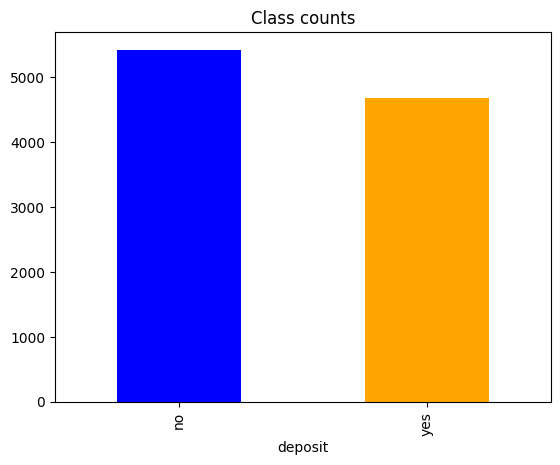

In [781]:
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class counts')

Text(0.5, 1.0, 'Distribution of Target Variable (Deposit)')

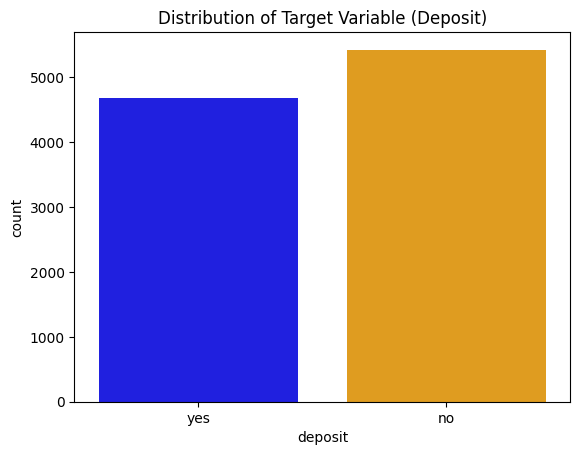

In [782]:
sns.countplot(x='deposit', data=df, palette=['blue', 'orange'])
plt.title('Distribution of Target Variable (Deposit)')

### Задания 2 и 3

In [783]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [784]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<Axes: xlabel='age'>

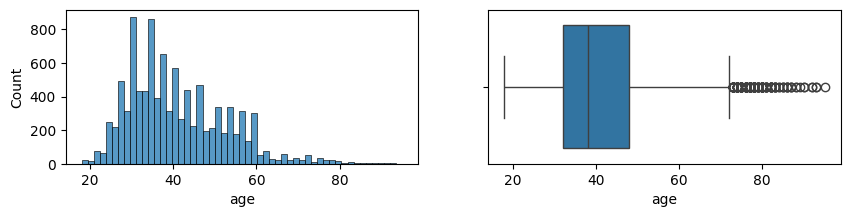

In [785]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

sns.histplot(x='age', data=df, ax=axes[0])
sns.boxplot(x='age', data=df, ax=axes[1])

### Задания 4 и 5

In [786]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


<Axes: xlabel='month', ylabel='count'>

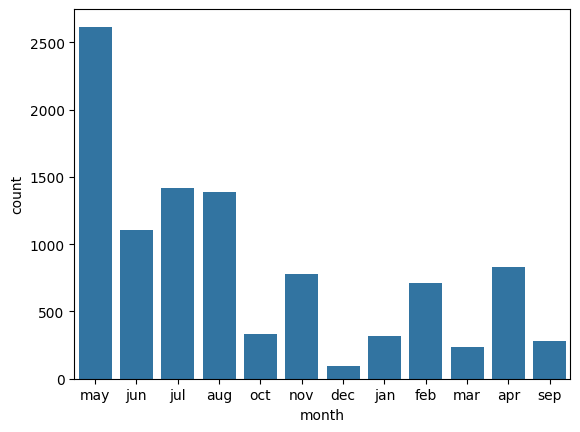

In [787]:
sns.countplot(x='month', data=df)

### Задание 6

In [788]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df.groupby('poutcome')['deposit'].value_counts(False).unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 7

In [789]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# Предположим, что в колонке 'deposit' хранится 0 - отказ, 1 - успех
# Сначала посчитаем общее количество взаимодействий по месяцам
total_interactions = df.groupby('month')['deposit'].count()

# Затем посчитаем количество отказов (где deposit == 0) по месяцам
failures = df[df['deposit'] == 'no'].groupby('month')['deposit'].count()

# Рассчитаем процент отказов для каждого месяца
failure_rate = (failures / total_interactions) * 100

# Найдем месяц с самым высоким процентом отказов
worst_month = failure_rate.idxmax()

# Выводим результат
print(f"Месяц с самым высоким процентом неудач: {worst_month}")
print(f"Процент неудач в этом месяце: {failure_rate[worst_month]:.2f}%")

Месяц с самым высоким процентом неудач: may
Процент неудач в этом месяце: 67.86%


### Задание 8

<Axes: xlabel='age_group', ylabel='count'>

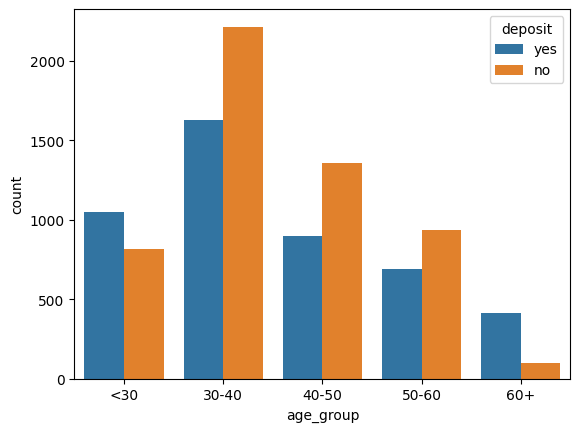

In [790]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels=['<30', '30-40', '40-50', '50-60', '60+'])
sns.countplot(x='age_group', hue='deposit', data=df)

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='count'>

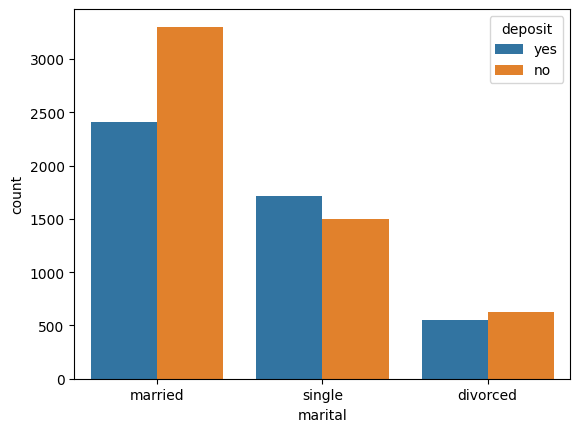

In [791]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

sns.countplot(x='marital', hue='deposit', data=df)

In [792]:
df.groupby('marital')['deposit'].value_counts().unstack()

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


<Axes: xlabel='education', ylabel='count'>

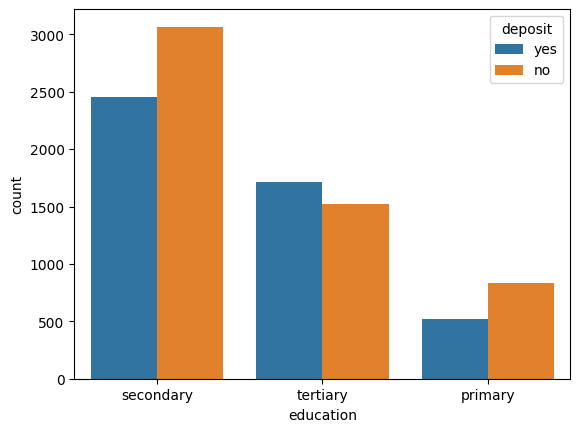

In [793]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

sns.countplot(x='education', hue='deposit', data=df)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'admin.'),
  Text(1, 0, 'technician'),
  Text(2, 0, 'services'),
  Text(3, 0, 'management'),
  Text(4, 0, 'retired'),
  Text(5, 0, 'blue-collar'),
  Text(6, 0, 'unemployed'),
  Text(7, 0, 'entrepreneur'),
  Text(8, 0, 'housemaid'),
  Text(9, 0, 'self-employed'),
  Text(10, 0, 'student')])

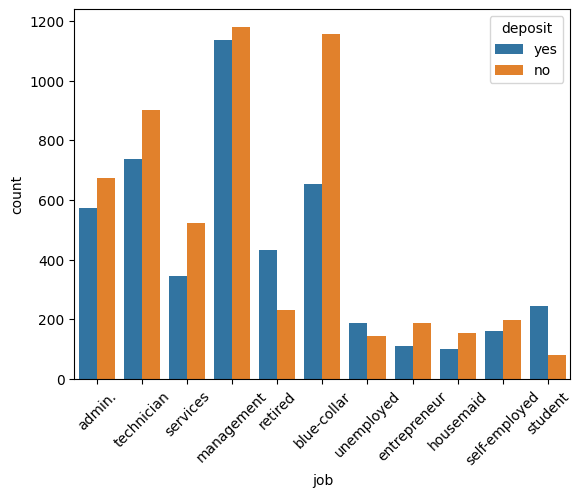

In [794]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

sns.countplot(x='job', hue='deposit', data=df, orient=100)
plt.xticks(rotation=45)

### Задание 11

In [795]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50


In [796]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

df_deposit_yes = df[df.deposit=='yes']
df_deposit_no = df[df.deposit=='no']

In [797]:
pivot_yes = pd.crosstab(df_deposit_yes.education, df_deposit_yes.marital)
pivot_no = pd.crosstab(df_deposit_no.education, df_deposit_no.marital)

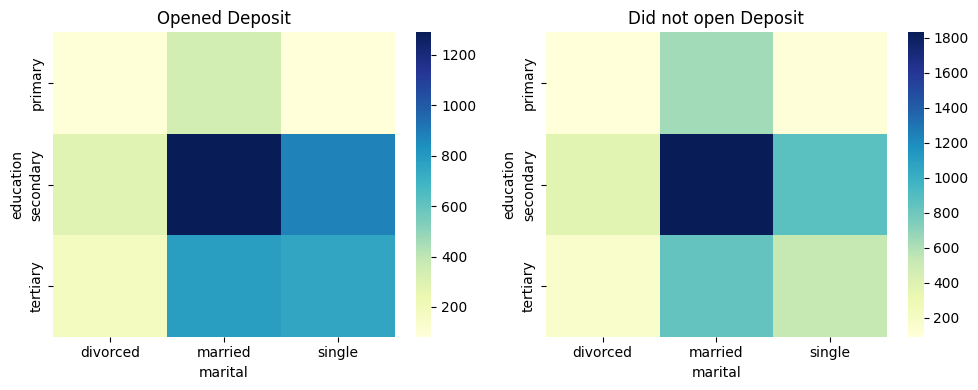

In [798]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(pivot_yes, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Opened Deposit')

sns.heatmap(pivot_no, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Did not open Deposit')

plt.tight_layout()
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [799]:
df.education.value_counts()

education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64

In [800]:
# преобразуйте уровни образования

from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
df['education'] = label_enc.fit_transform(df.education)

In [801]:
df.education.sum()

np.int64(11995)

In [802]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
df['age_group'] = oe.fit_transform(df[['age_group']])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2.0
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2.0
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1.0
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2.0
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2.0


### Задания 2 и 3

In [803]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df.deposit = df.deposit.apply(lambda x: 1 if x=='yes' else 0)

In [804]:
round(df.deposit.std(), 3)

np.float64(0.499)

In [805]:
df.default = df.default.apply(lambda x: 1 if x=='yes' else 0)
df.housing = df.housing.apply(lambda x: 1 if x=='yes' else 0)
df.loan = df.loan.apply(lambda x: 1 if x=='yes' else 0)

In [806]:
round(df.default.mean() + df.housing.mean() + df.loan.mean(), 3)

np.float64(0.635)

### Задание 4

In [807]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2.0
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2.0
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1.0
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2.0
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2.0


In [808]:
# создайте дамми-переменные

df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df.shape

(10105, 46)

### Задания 5 и 6

<Axes: >

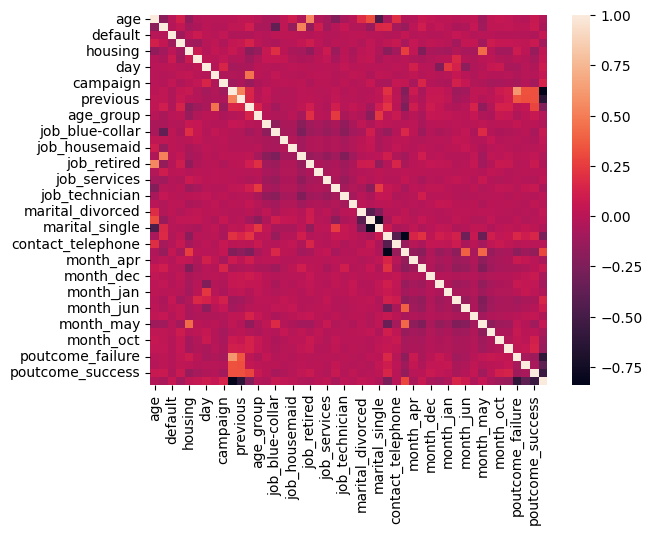

In [809]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

df_corr = df.corr()
sns.heatmap(df.corr())

In [810]:
df_corr.unstack().sort_values(ascending=False)

age                age                  1.000000
job_unemployed     job_unemployed       1.000000
job_student        job_student          1.000000
job_services       job_services         1.000000
job_self-employed  job_self-employed    1.000000
                                          ...   
marital_single     marital_married     -0.779038
pdays              poutcome_unknown    -0.824031
poutcome_unknown   pdays               -0.824031
contact_cellular   contact_unknown     -0.837885
contact_unknown    contact_cellular    -0.837885
Length: 2116, dtype: float64

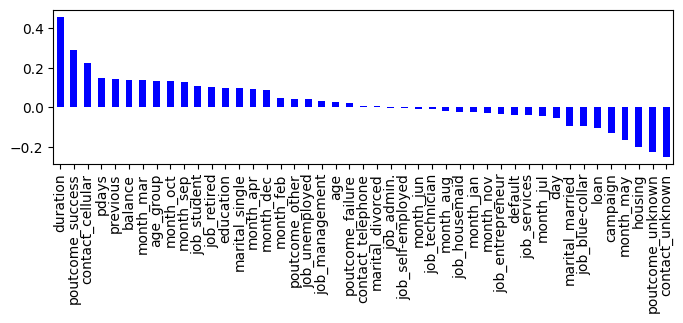

In [811]:
target_corr = df_corr['deposit'].sort_values(ascending=False)

plt.figure(figsize=(8, 2))
target_corr.drop('deposit').plot(kind='bar', color='blue')
plt.show()

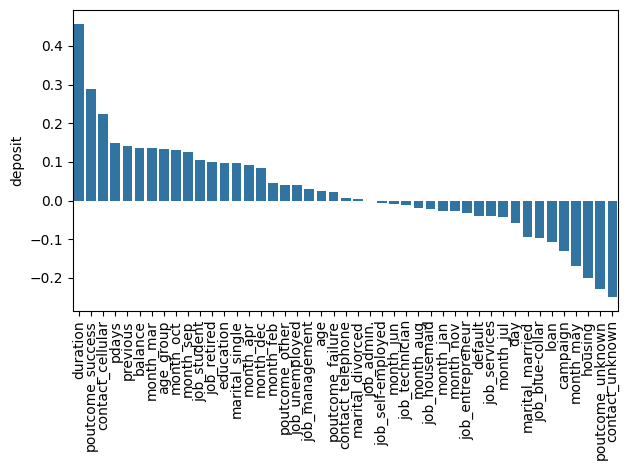

In [812]:
sns.barplot(data=target_corr.drop('deposit'))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Axes: >

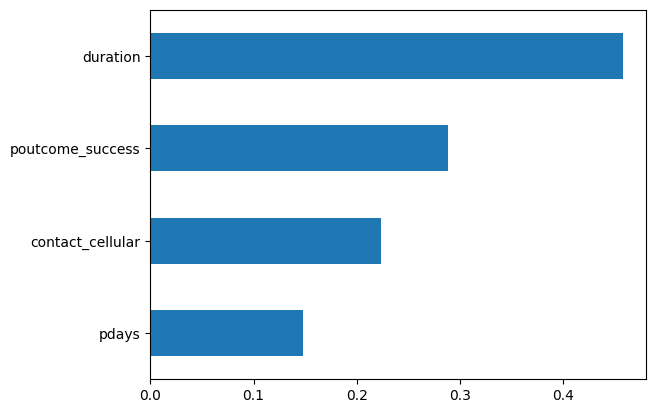

In [813]:
df_corr['deposit'].sort_values()[-5:-1].plot.barh()

### Задания 7 и 8

In [814]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size = 0.33)

In [815]:
# рассчитайте необходимые показатели
print(X_test.shape)
print(round(y_test.mean(), 2))

(3335, 45)
0.46


### Задание 9

In [816]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [817]:
X_train, X_test = X_train[selector.get_feature_names_out()], X_test[selector.get_feature_names_out()] 

### Задание 10

In [818]:
# нормализуйте данные с помощью minmaxsxaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [819]:
round(X_test_scaled[:, 0].mean(), 2)

np.float64(0.47)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [827]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_test_pred = log_reg.predict(X_test_scaled)
print(f'Logistic regression accuracy for test set:\n {metrics.classification_report(y_test, y_test_pred)}')

Logistic regression accuracy for test set:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [828]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train_scaled, y_train)

y_test_pred = dt.predict(X_test_scaled)
print(f'Decision tree results on test set:\n {metrics.classification_report(y_test, y_test_pred)}')

Decision tree results on test set:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



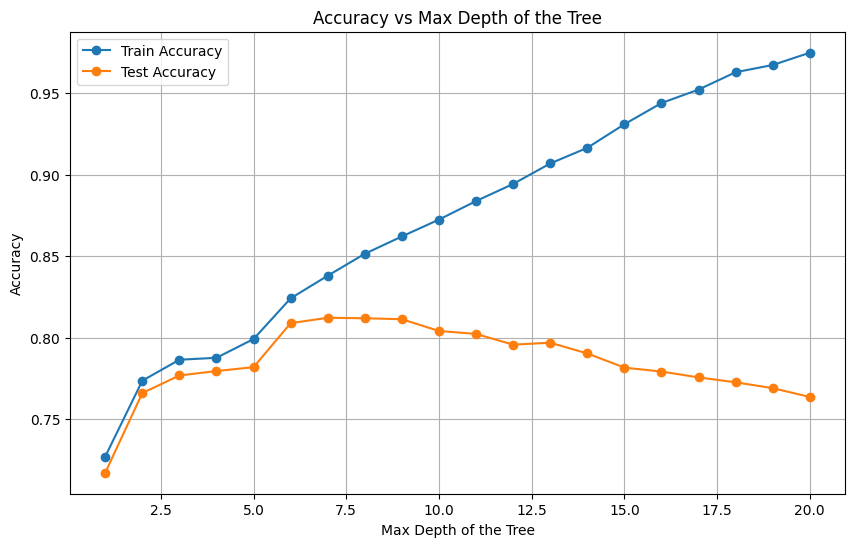

In [829]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Диапазон значений глубины дерева для перебора
max_depths = range(1, 21)

# Списки для хранения значений accuracy
train_accuracies = []
test_accuracies = []

# Перебор различных значений глубины дерева
for max_depth in max_depths:
    # Создаем модель с текущей глубиной дерева
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Предсказания для обучающей и тестовой выборок
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Расчет accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Сохранение результатов
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Построение графиков accuracy
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth of the Tree')
plt.legend()
plt.grid(True)
plt.show()

In [836]:
max(test_accuracies)

0.8122938530734632

In [845]:
# max_depth=6

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train_scaled, y_train)

y_test_pred = dt.predict(X_test_scaled)
print(f'Decision tree results on test set:\n {metrics.classification_report(y_test, y_test_pred)}')

Decision tree results on test set:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [850]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring=('f1'),
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)
y_test_pred = grid_search.predict(X_test_scaled)

print(f'f1 score for test set: {metrics.f1_score(y_test, y_test_pred)}')
print(f'Best hypetparameters: {grid_search.best_params_}')

f1 score for test set: 0.801404853128991
Best hypetparameters: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [853]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)

print(f'Classification report for Random Forest on test data:\n\n {metrics.classification_report(y_test, y_test_pred)}')

Classification report for Random Forest on test data:

               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [854]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gb.fit(X_train_scaled, y_train)
y_test_pred = gb.predict(X_test_scaled)
print(f'f1 score for GradientBoosting on test set: {metrics.f1_score(y_test, y_test_pred)}')

f1 score for GradientBoosting on test set: 0.8161321054302954


In [857]:
print(f'classification report for GradientBoosting on test set:\n\n {metrics.classification_report(y_test, y_test_pred)}')

classification report for GradientBoosting on test set:

               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [882]:
# объедините уже известные вам алгоритмы с помощью стекинга 

from sklearn.ensemble import StackingClassifier

estimators = [
    ('dt', DecisionTreeClassifier(criterion='entropy',
                                  random_state=42,
                                  max_depth=6)),
    ('log_reg', linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('gb', ensemble.GradientBoostingClassifier(learning_rate = 0.05, 
                                               n_estimators = 300, 
                                               min_samples_leaf = 5, 
                                               max_depth = 5, 
                                               random_state = 42))
]

stacking_class = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
)

stacking_class.fit(X_train_scaled, y_train)
y_test_pred = stacking_class.predict(X_test_scaled)
print(f'Classification report for Stacking on test set:\n\n {metrics.classification_report(y_test, y_test_pred)}')

Classification report for Stacking on test set:

               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [884]:
print(f'f1 score for Stacking on test set: {metrics.f1_score(y_test, y_test_pred)}')
print(f'accuracy score for Stacking on test set: {metrics.accuracy_score(y_test, y_test_pred)}')

f1 score for Stacking on test set: 0.8102166181700614
accuracy score for Stacking on test set: 0.8239880059970015


### Задание 5

In [864]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
importances = gb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importance_df

,Feature,Importance
0,balance,0.057952
1,housing,0.047725
2,duration,0.507106
3,campaign,0.014777
4,pdays,0.055145
5,previous,0.008305
6,age_group,0.039902
7,contact_cellular,0.003620
8,contact_unknown,0.072582
9,month_mar,0.027819


In [867]:
feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072582
0,balance,0.057952
4,pdays,0.055145
1,housing,0.047725
6,age_group,0.039902
9,month_mar,0.027819
11,month_oct,0.019880
10,month_may,0.015245


### Задания 6,7,8

In [878]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [879]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=50)

[I 2024-09-03 12:36:43,592] A new study created in memory with name: RandomForestClassifier
[I 2024-09-03 12:36:44,494] Trial 0 finished with value: 0.8447517284726587 and parameters: {'n_estimators': 197, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8447517284726587.
[I 2024-09-03 12:36:45,037] Trial 1 finished with value: 0.8611544461778471 and parameters: {'n_estimators': 161, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8611544461778471.
[I 2024-09-03 12:36:45,360] Trial 2 finished with value: 0.85705378020265 and parameters: {'n_estimators': 103, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8611544461778471.
[I 2024-09-03 12:36:45,833] Trial 3 finished with value: 0.8603961940414911 and parameters: {'n_estimators': 149, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8611544461778471.
[I 2024-09-03 12:36:46,291] Trial 4 finished with value: 0.8495547570692079 and parameters: {'n_es

In [881]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
#y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
